# Import Dataset & Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\samsung\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
card=pd.read_csv('C:\\Users\\samsung\\Downloads\\creditcard.csv')

In [5]:
print(card.shape)
print(card.columns)

(12956, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
card.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
12951,22764,-0.639986,-0.178441,2.264136,3.321201,-1.699491,1.045885,1.091610,-0.127544,0.708780,...,0.400474,0.882306,0.901366,0.249826,-0.950593,0.145473,-0.075707,0.013503,403.39,0.0
12952,22766,-1.004829,0.558830,2.073444,-1.414930,-0.021340,-1.170492,0.568254,-0.267659,2.182065,...,-0.087044,0.213624,-0.410027,0.722557,0.828432,-0.733956,-0.090290,0.104562,5.00,0.0
12953,22766,1.186337,-0.264196,1.028314,-0.569882,-0.892032,-0.286049,-0.677396,-0.020995,2.986773,...,-0.119936,0.198725,-0.013010,0.058321,0.425846,-0.699178,0.086295,0.028986,11.85,0.0
12954,22768,1.142523,-0.424387,1.016466,-0.671865,-0.967416,0.004548,-0.882903,0.212113,2.955977,...,-0.085791,0.186966,-0.007680,-0.039204,0.345016,-0.711399,0.072600,0.015535,11.85,0.0
12955,22773,1.206604,0.281490,-0.502409,1.719251,2.235367,4.115061,-0.711824,0.916170,0.874006,...,-0.492132,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
card.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

In [8]:
card = card.dropna()

In [9]:
X = card.iloc[:,1:30]
Y = card.iloc[:,30]

In [22]:
Y.mean()

0.004322655345426476

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_train,X_val,Y_train,Y_val = train_test_split(X_scaled,Y,test_size=0.33,
                                              random_state=123,stratify=Y)

In [12]:
X_scaled.shape,X_train.shape,X_val.shape

((12955, 29), (8679, 29), (4276, 29))

# Defining Functions

## Anomaly Scores

- 각 거래가 "얼마나 비정상인지"를 측정 
- "재구성 오차" ( 원본 행렬 vs 차원축소 이후 재구성된 행렬 )
- 0~1 사이로 scaling 
- 0 : 정상 & 1 : 비정상

In [13]:
def anomaly(df_org,df_new):
    loss = pd.Series(np.sum((np.array(df_org)-np.array(df_new))**2, axis=1),index=df_org.index)
    score = (loss-np.min(loss)) / (np.max(loss)-np.min(loss))
    return score

## Performance Metrics

In [14]:
from sklearn.metrics import auc,roc_curve,average_precision_score,precision_recall_curve

In [132]:
def performance(y_actual,anomaly,viz=False):
    pred= pd.concat([y_actual,anomaly],axis=1)
    pred.columns = ['Y','ANOMALY']        
    
    prec,rec,thres1 = precision_recall_curve(pred['Y'],pred['ANOMALY'])
    avg_precision = average_precision_score(pred['Y'],pred['ANOMALY'])
    fpr,tpr,thres2 = roc_curve(pred['Y'],pred['ANOMALY'])    
    AUC = auc(fpr,tpr)
    
    if viz is False:        
        print('Average Precision = {0:0.2f}'.format(avg_precision))
        print('Area Under Curve (AUC) = {0:0.2f}'.format(AUC))
        return avg_precision,AUC
    else :
        plt.step(rec,prec,color='k',alpha=0.8,where='post')
        plt.fill_between(rec,prec,step='post',alpha=0.2,color='k')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('[ Precision-Recall-Curve ] ')
        
        plt.figure()
        plt.plot(fpr,tpr,color='r',lw=2,label='ROC Curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('[ ROC curve ]')
        plt.legend(loc='lower right')
        plt.show()     
        

In [133]:
def performance2(y_actual,anomaly,cut_off):
    pred= pd.concat([y_actual,anomaly],axis=1)
    pred.columns = ['Y','ANOMALY']
    pred = pred.sort_values(by='ANOMALY',ascending=False)
    pred_top = pred[:cut_off]
    precision = pred_top['ANOMALY'][pred_top['Y']==1].count() / cut_off
    recall = pred_top['ANOMALY'][pred_top['Y']==1].count() / Y.sum()
    print("[ Precision ] ",np.round(precision,2))
    print("[ Recall ] ",np.round(recall,2))
    print("Out of {} cases, Caught {} cases".format(cut_off,pred_top['Y'].sum()))
    return precision,recall,pred_top['Y'].sum()

## Scatter Plot

In [17]:
def scatter(reduced_df,y_df,method):
    temp = pd.DataFrame(reduced_df.iloc[:,0:2],index=reduced_df.index)
    plot_df = pd.concat([temp,y_df],axis=1,join='inner')
    plot_df.columns = ['PC1','PC2','Class']
    sns.scatterplot(x='PC1',y='PC2',hue='Class',data=plot_df)
    ax = plt.gca()
    ax.set_title('Algorithm : '+method)

# Anomaly Detection

In [18]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import MiniBatchDictionaryLearning,FastICA

## PCA

In [136]:
pca = PCA(n_components=X_scaled.shape[1],random_state=123)
pca.fit(X_train)
pca.explained_variance_ratio_.cumsum().round(3)

array([0.113, 0.185, 0.253, 0.311, 0.365, 0.412, 0.457, 0.499, 0.538,
       0.576, 0.613, 0.648, 0.682, 0.715, 0.745, 0.774, 0.801, 0.827,
       0.852, 0.875, 0.897, 0.917, 0.935, 0.952, 0.967, 0.981, 0.991,
       1.   , 1.   ])

In [137]:
pca = PCA(n_components=12,random_state=123)
X_train_pca = pca.fit_transform(X_train)
X_train_pca_df = pd.DataFrame(X_train_pca, index=X_train.index)
X_train_pca_inv = pca.inverse_transform(X_train_pca_df)
X_train_pca_inv_df = pd.DataFrame(X_train_pca_inv, index=X_train.index)

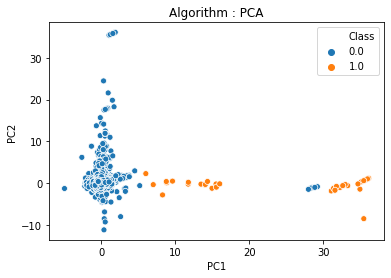

In [138]:
scatter(X_train_pca_df,Y_train,'PCA')

In [139]:
anomaly_scores = anomaly(X_train,X_train_pca_inv_df)

In [140]:
pca_avgpre,pca_auc = performance(Y_train,anomaly_scores)

Average Precision = 0.13
Area Under Curve (AUC) = 0.94


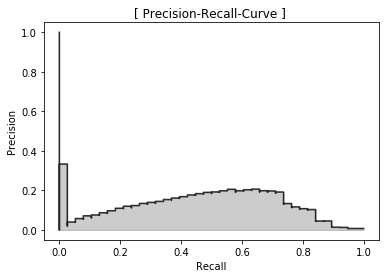

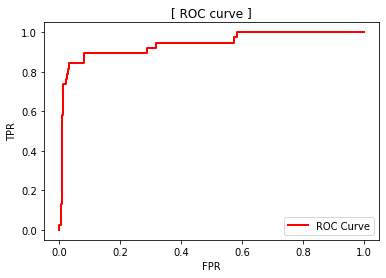

In [142]:
performance(Y_train,anomaly_scores,viz=True)

In [143]:
pca_pre,pca_rec,pca_caught = performance2(Y_train,anomaly_scores,200)

[ Precision ]  0.14
[ Recall ]  0.5
Out of 200 cases, Caught 28.0 cases


## Kernel PCA

In [28]:
ker_pca = KernelPCA(n_components=10,kernel='rbf',n_jobs=1,
                fit_inverse_transform=True,random_state=123)
ker_pca.fit(X_train)

X_train_kerpca = ker_pca.transform(X_train)
X_train_kerpca_df = pd.DataFrame(X_train_kerpca, index=X_train.index)
X_train_kerpca_inv = ker_pca.inverse_transform(X_train_kerpca_df)
X_train_kerpca_inv_df = pd.DataFrame(X_train_kerpca_inv, index=X_train.index)

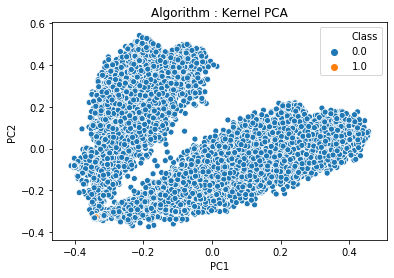

In [31]:
scatter(X_train_kerpca_df,Y_train,'Kernel PCA')

In [161]:
anomaly_scores = anomaly(X_train,X_train_kerpca_inv_df)

In [162]:
kerpca_avgpre,kerpca_auc = performance(Y_train,anomaly_scores)

Average Precision = 0.34
Area Under Curve (AUC) = 0.96


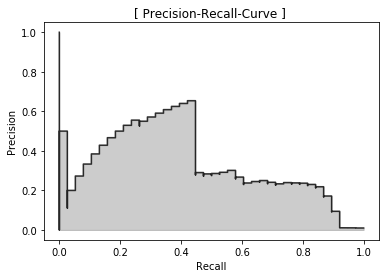

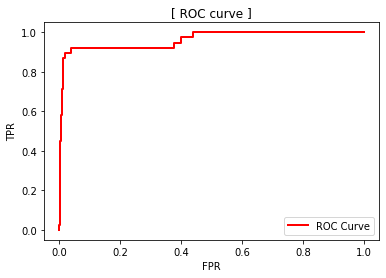

In [163]:
performance(Y_train,anomaly_scores,viz=True)

In [164]:
kerpca_pre,kerpca_rec,kerpca_caught = performance2(Y_train,anomaly_scores,200)

[ Precision ]  0.17
[ Recall ]  0.61
Out of 200 cases, Caught 34.0 cases


## Gaussian Random Projection

- inverse_transform 제공 X ( 직접 구현해야 )

In [75]:
grp = GaussianRandomProjection(n_components=15,eps=None,random_state=123)

X_train_grp = grp.fit_transform(X_train)
X_train_grp_df = pd.DataFrame(X_train_grp, index=X_train.index)
X_train_grp_inv = np.array(X_train_grp_df).dot(grp.components_) 
X_train_grp_inv_df = pd.DataFrame(X_train_grp_inv, index=X_train.index)

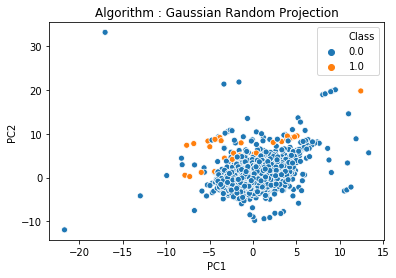

In [76]:
scatter(X_train_grp_df,Y_train,'Gaussian Random Projection')

In [147]:
anomaly_scores = anomaly(X_train,X_train_grp_inv_df)

In [150]:
grp_avgpre,grp_auc = performance(Y_train,anomaly_scores)

Average Precision = 0.26
Area Under Curve (AUC) = 0.96


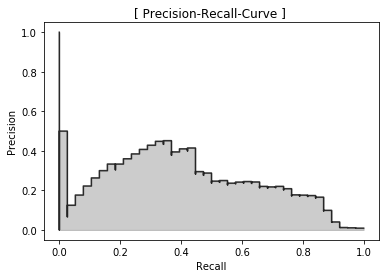

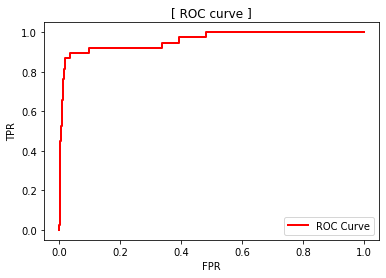

In [149]:
performance(Y_train,anomaly_scores,viz=True)

In [79]:
grp_pre,grp_rec,grp_caught = performance2(Y_train,anomaly_scores,200)

[ Precision ]  0.16
[ Recall ]  0.59
Out of 200 cases, Caught 33.0 cases


## Dicitonary Learning

In [118]:
mbDL = MiniBatchDictionaryLearning(n_components=10,alpha=1,
                                   batch_size=16,random_state=123)
mbDL.fit(X_train)

X_train_dl = mbDL.fit_transform(X_train)
X_train_dl_df = pd.DataFrame(X_train_dl, index=X_train.index)
X_train_dl_inv = np.array(X_train_dl_df).dot(mbDL.components_) 
X_train_dl_inv_df = pd.DataFrame(X_train_dl_inv, index=X_train.index)

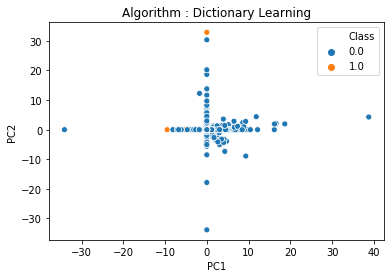

In [122]:
scatter(X_train_dl_df,Y_train,'Dictionary Learning')

In [166]:
anomaly_scores = anomaly(X_train,X_train_dl_inv_df)

In [167]:
dl_avgpre,dl_auc = performance(Y_train,anomaly_scores)

Average Precision = 0.14
Area Under Curve (AUC) = 0.94


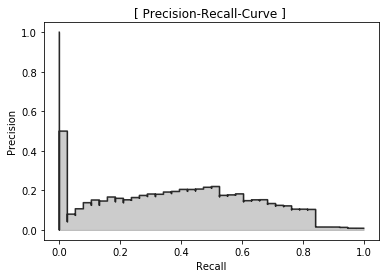

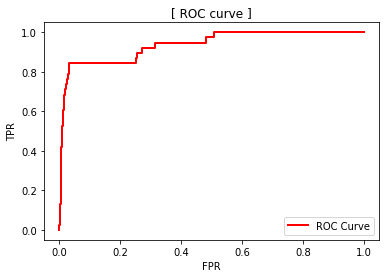

In [168]:
performance(Y_train,anomaly_scores,viz=True)

In [169]:
dl_pre,dl_rec,dl_caught = performance2(Y_train,anomaly_scores,200)

[ Precision ]  0.13
[ Recall ]  0.46
Out of 200 cases, Caught 26.0 cases


## ICA

In [126]:
ica = FastICA(n_components=10,algorithm='parallel',whiten=True,
             max_iter=200,random_state=123)

X_train_ica = ica.fit_transform(X_train)
X_train_ica_df = pd.DataFrame(X_train_ica, index=X_train.index)
X_train_ica_inv = ica.inverse_transform(X_train_ica_df)
X_train_ica_inv_df = pd.DataFrame(X_train_dl_inv, index=X_train.index)

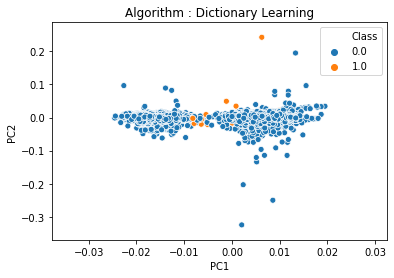

In [128]:
scatter(X_train_ica_df,Y_train,'Dictionary Learning')

In [155]:
anomaly_scores = anomaly(X_train,X_train_ica_inv_df)

In [157]:
ica_avgpre,ica_auc = performance(Y_train,anomaly_scores)

Average Precision = 0.14
Area Under Curve (AUC) = 0.94


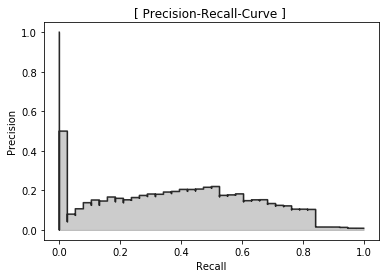

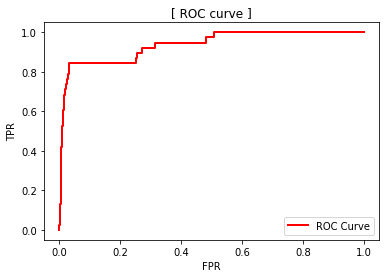

In [156]:
performance(Y_train,anomaly_scores,viz=True)

In [158]:
ica_pre,ica_rec,ica_caught = performance2(Y_train,anomaly_scores,200)

[ Precision ]  0.13
[ Recall ]  0.46
Out of 200 cases, Caught 26.0 cases


In [170]:
pca_train_result = [pca_avgpre,pca_auc,pca_pre,pca_rec,pca_caught]
kerpca_train_result = [kerpca_avgpre,kerpca_auc,kerpca_pre,kerpca_rec,kerpca_caught]
grp_train_result = [grp_avgpre,grp_auc,grp_pre,grp_rec,grp_caught]
dl_train_result = [dl_avgpre,dl_auc,dl_pre,dl_rec,dl_caught]
ica_train_result = [ica_avgpre,ica_auc,ica_pre,ica_rec,ica_caught]

In [184]:
train_result = pd.DataFrame([pca_train_result,kerpca_train_result,grp_train_result,
             dl_train_result,ica_train_result]).T
train_result.columns = ['PCA','KerPCA','GRP','DL','ICA']
train_result.index = ['AvgPre','AUC','Pre','Rec','Caught(/350)']

In [186]:
train_result.round(2)

,PCA,KerPCA,GRP,DL,ICA
AvgPre,0.13,0.34,0.26,0.14,0.14
AUC,0.94,0.96,0.96,0.94,0.94
Pre,0.14,0.17,0.13,0.13,0.13
Rec,0.50,0.61,0.46,0.46,0.46
Caught(/350),28.00,34.00,26.00,26.00,26.00
